# Credit Card Customer Segmentation

## The problem

A marketing strategy team is trying to buid new [personas](https://www.interaction-design.org/literature/article/personas-why-and-how-you-should-use-them) so the marketing campaing is more accurate and achieve a higher return on investment (ROI).

Saying this, the problem can be described as a customer segmentation task. 
Hence, to tackle the problem we will try to follow the suitable steps of a well known data science methodology - CRISP.

1. **Understand the  business problem**; 
2. **Understand the data**;
3. **Prepare the data**;
4. **Modeling**;
5. **Evaluation**;
6. **Deploy** (Of course, for this problem, we will not deploy any model. Altough, this project may evolve in the future)


## The Data
The data summarizes the usage of 9000 credit card holders during 6 months, so the variable intend to capture the behavioural of those customers.

- **CUSTID** : Identification of Credit Card holder. (ID)
- **BALANCE** : Balance amount left in their account to make purchases 
- **BALANCEFREQUENCY** : How frequently the Balance is updated, score between 0 and 1 (1 = frequently updated, 0 = not frequently updated)
- **PURCHASES** : Amount of purchases made from account
- **ONEOFFPURCHASES** : Maximum purchase amount done in one-go
- **INSTALLMENTSPURCHASES** : Amount of purchase done in installment
- **CASHADVANCE** : Cash in advance given by the user
- **PURCHASESFREQUENCY** : How frequently the Purchases are being made, score between 0 and 1 (1 = frequently purchased, 0 = not frequently purchased)
- **ONEOFFPURCHASESFREQUENCY** : How frequently Purchases are happening in one-go (1 = frequently purchased, 0 = not frequently purchased)
- **PURCHASESINSTALLMENTSFREQUENCY** : How frequently purchases in installments are being done (1 = frequently done, 0 = not frequently done)
- **CASHADVANCEFREQUENCY** : How frequently the cash in advance being paid
- **CASHADVANCETRX** : Number of Transactions made with "Cash in Advanced"
- **PURCHASESTRX** : Number of purchase transactions made
- **CREDITLIMIT** : Limit of Credit Card for user
- **PAYMENTS** : Amount of Payment done by user
- **MINIMUM_PAYMENTS** : Minimum amount of payments made by user
- **PRCFULLPAYMENT** : Percent of full payment paid by user
- **TENURE** : Tenure of credit card service for user

# Packages

In [28]:
# os / sys 
import os 
import sys
import warnings


# standard

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

from glob import glob

# stats 

from scipy.stats import norm 

# machine learning

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score



In [2]:
# global configs
%matplotlib inline
warnings.filterwarnings('ignore')
sns.set_theme()
sns.set_style('whitegrid')

# Loading Data

In [3]:
file = glob('raw/*.csv')

raw_df = pd.read_csv(file[0], index_col = 'CUST_ID')
raw_df

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
CUST_ID,,,,,,,,,,,,,,,,,
C10001,40.900749,0.818182,95.40,0.00,95.40,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
C10002,3202.467416,0.909091,0.00,0.00,0.00,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
C10003,2495.148862,1.000000,773.17,773.17,0.00,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
C10004,1666.670542,0.636364,1499.00,1499.00,0.00,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
C10005,817.714335,1.000000,16.00,16.00,0.00,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C19186,28.493517,1.000000,291.12,0.00,291.12,0.000000,1.000000,0.000000,0.833333,0.000000,0,6,1000.0,325.594462,48.886365,0.500000,6
C19187,19.183215,1.000000,300.00,0.00,300.00,0.000000,1.000000,0.000000,0.833333,0.000000,0,6,1000.0,275.861322,NaN,0.000000,6
C19188,23.398673,0.833333,144.40,0.00,144.40,0.000000,0.833333,0.000000,0.666667,0.000000,0,5,1000.0,81.270775,82.418369,0.250000,6


# Exploratory Data Analysis

After this section of the project, those are the criteria that needs to be met:
- Missing Values
- Columns Type
- Distributions
- Relationship between columns ( correlation, interaction).

In [4]:
# Missing values
def check_missing(data):
    
    # columns that have NA
    mask_columns_na = raw_df.columns[raw_df.isna().any()]
    
    # Value counts of NA
    na_count = raw_df[mask_columns_na].isna().sum()
    
    percentage_na = (raw_df[mask_columns_na].isna().sum()/len(raw_df)) * 100
    df_na = pd.DataFrame({'NA Values': na_count, 'Percentage NA': percentage_na})
    df_na = df_na.sort_values(by = 'Percentage NA', ascending = False)
    
    return print(df_na)

check_missing(raw_df)     

                  NA Values  Percentage NA
MINIMUM_PAYMENTS        313       3.497207
CREDIT_LIMIT              1       0.011173


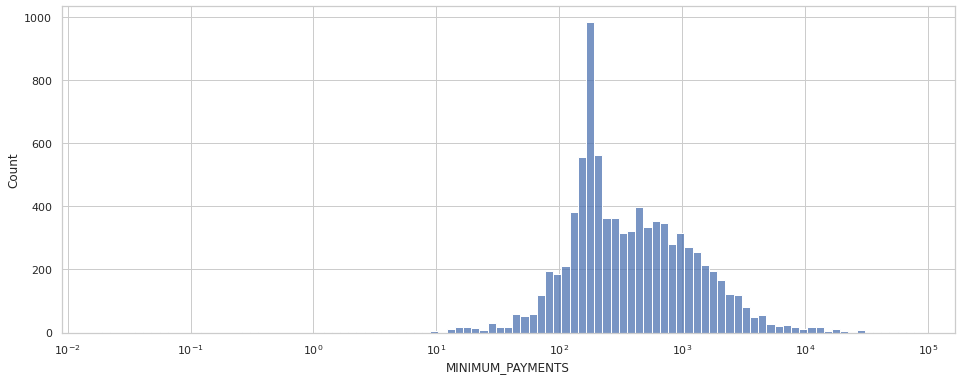

--------------------------------------------------
The number of CC holders that havent paid anything is: 0


In [5]:
# Payments
plt.figure(figsize= (16,6))
sns.histplot(raw_df, x = 'MINIMUM_PAYMENTS', log_scale = True)
plt.show()

print('-'*50)
print( 'The number of CC holders that havent paid anything is: {}'.format(sum(raw_df['MINIMUM_PAYMENTS'] == 0)))

Well, the hypothesis of having zero cc holders that havent paid anything doensn't seems plausible to me, so lets give it a fast look of some of those NA occurrences.
To be more precise, we're looking for behaviour consistent with not paying anything.

In [6]:
raw_df[raw_df['MINIMUM_PAYMENTS'].isna()]

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
CUST_ID,,,,,,,,,,,,,,,,,
C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.0,12
C10047,2242.311686,1.000000,437.00,97.00,340.0,184.648692,0.333333,0.083333,0.333333,0.166667,2,5,2400.0,0.000000,NaN,0.0,12
C10049,3910.111237,1.000000,0.00,0.00,0.0,1980.873201,0.000000,0.000000,0.000000,0.500000,7,0,4200.0,0.000000,NaN,0.0,12
C10056,6.660517,0.636364,310.00,0.00,310.0,0.000000,0.666667,0.000000,0.666667,0.000000,0,8,1000.0,417.016763,NaN,0.0,12
C10057,1311.995984,1.000000,1283.90,1283.90,0.0,0.000000,0.250000,0.250000,0.000000,0.000000,0,6,6000.0,0.000000,NaN,0.0,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C19160,14.524779,0.333333,152.00,152.00,0.0,0.000000,0.333333,0.333333,0.000000,0.000000,0,2,1500.0,0.000000,NaN,0.0,6
C19170,371.527312,0.333333,0.00,0.00,0.0,1465.407927,0.000000,0.000000,0.000000,0.166667,5,0,1500.0,0.000000,NaN,0.0,6
C19176,183.817004,1.000000,465.90,0.00,465.9,0.000000,1.000000,0.000000,0.833333,0.000000,0,6,1500.0,0.000000,NaN,0.0,6


Okey, so it seem's my hypothesis is 80% correct. As we can see, a lot of rows that has NA's the paymements columns is equal to zero.

In [7]:
mask_zero_pay = raw_df['PAYMENTS'] == 0.0 
raw_df.loc[mask_zero_pay, 'MINIMUM_PAYMENTS'] = raw_df.loc[mask_zero_pay, 'MINIMUM_PAYMENTS'].fillna(0)
    
check_missing(raw_df)
raw_df[raw_df['MINIMUM_PAYMENTS'].isna()]

                  NA Values  Percentage NA
MINIMUM_PAYMENTS         73       0.815642
CREDIT_LIMIT              1       0.011173


,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
CUST_ID,,,,,,,,,,,,,,,,,
C10056,6.660517,0.636364,310.00,0.00,310.00,0.000000,0.666667,0.000000,0.666667,0.000000,0,8,1000.0,417.016763,NaN,0.0,12
C10104,0.000000,0.000000,0.00,0.00,0.00,89.849004,0.000000,0.000000,0.000000,0.142857,1,0,3000.0,138.021428,NaN,0.0,7
C10152,19.354559,0.909091,689.70,0.00,689.70,0.000000,0.833333,0.000000,0.833333,0.000000,0,10,10000.0,746.691026,NaN,0.0,12
C10330,0.478714,0.090909,734.97,159.00,575.97,0.000000,0.833333,0.083333,0.750000,0.000000,0,16,6000.0,1159.135064,NaN,0.0,12
C11198,34.207779,0.090909,2483.26,2483.26,0.00,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,10000.0,29272.486070,NaN,0.0,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C18794,3.229304,0.545455,190.20,0.00,190.20,0.000000,0.666667,0.000000,0.583333,0.000000,0,8,1500.0,295.937124,NaN,0.0,12
C18827,16.887571,0.363636,1083.00,1083.00,0.00,0.000000,0.250000,0.250000,0.000000,0.000000,0,3,1200.0,3905.430817,NaN,0.0,12
C18882,0.006651,0.142857,0.00,0.00,0.00,164.137866,0.000000,0.000000,0.000000,0.142857,1,0,1200.0,5.070726,NaN,0.0,7


Well, now we have less than 1% of the data missing, so we have two options:

- Undertand why and imput some descriptive stats (mean, median)
- drop 

In practice, this a tradeoff between time (money) x return. I don't think that of less than 1% of the data would give me a better return on time. 
I will drop those rows.

In [8]:
raw_df.dropna(how = 'any', axis = 0, inplace = True)


In [9]:
raw_df.dtypes

BALANCE                             float64
BALANCE_FREQUENCY                   float64
PURCHASES                           float64
ONEOFF_PURCHASES                    float64
INSTALLMENTS_PURCHASES              float64
CASH_ADVANCE                        float64
PURCHASES_FREQUENCY                 float64
ONEOFF_PURCHASES_FREQUENCY          float64
PURCHASES_INSTALLMENTS_FREQUENCY    float64
CASH_ADVANCE_FREQUENCY              float64
CASH_ADVANCE_TRX                      int64
PURCHASES_TRX                         int64
CREDIT_LIMIT                        float64
PAYMENTS                            float64
MINIMUM_PAYMENTS                    float64
PRC_FULL_PAYMENT                    float64
TENURE                                int64
dtype: object

In [10]:
raw_df.describe()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
count,8876.000000,8876.000000,8876.000000,8876.000000,8876.000000,8876.000000,8876.000000,8876.000000,8876.000000,8876.000000,8876.000000,8876.000000,8876.000000,8876.000000,8876.000000,8876.000000,8876.000000
mean,1577.476910,0.883452,1008.892025,596.207416,412.987294,986.740505,0.490281,0.203786,0.363744,0.136146,3.274786,14.781095,4505.872931,1736.227227,840.934823,0.154996,11.519153
std,2085.293942,0.226830,2144.269272,1665.821023,907.676627,2104.077896,0.401426,0.299009,0.397288,0.200619,6.847019,24.944350,3645.928272,2884.755113,2344.462258,0.293378,1.335780
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.000000,0.000000,0.000000,0.000000,6.000000
25%,134.884479,0.900000,37.877500,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,1.000000,1600.000000,385.803965,164.371044,0.000000,12.000000
50%,889.861455,1.000000,365.000000,40.000000,88.560000,0.000000,0.500000,0.083333,0.166667,0.000000,0.000000,7.000000,3000.000000,863.850870,294.587445,0.000000,12.000000
75%,2071.982170,1.000000,1119.742500,585.937500,470.030000,1126.499747,0.916667,0.333333,0.750000,0.250000,4.000000,17.000000,6500.000000,1908.377537,795.421825,0.142857,12.000000
max,19043.138560,1.000000,49039.570000,40761.250000,22500.000000,47137.211760,1.000000,1.000000,1.000000,1.500000,123.000000,358.000000,30000.000000,50721.483360,76406.207520,1.000000,12.000000


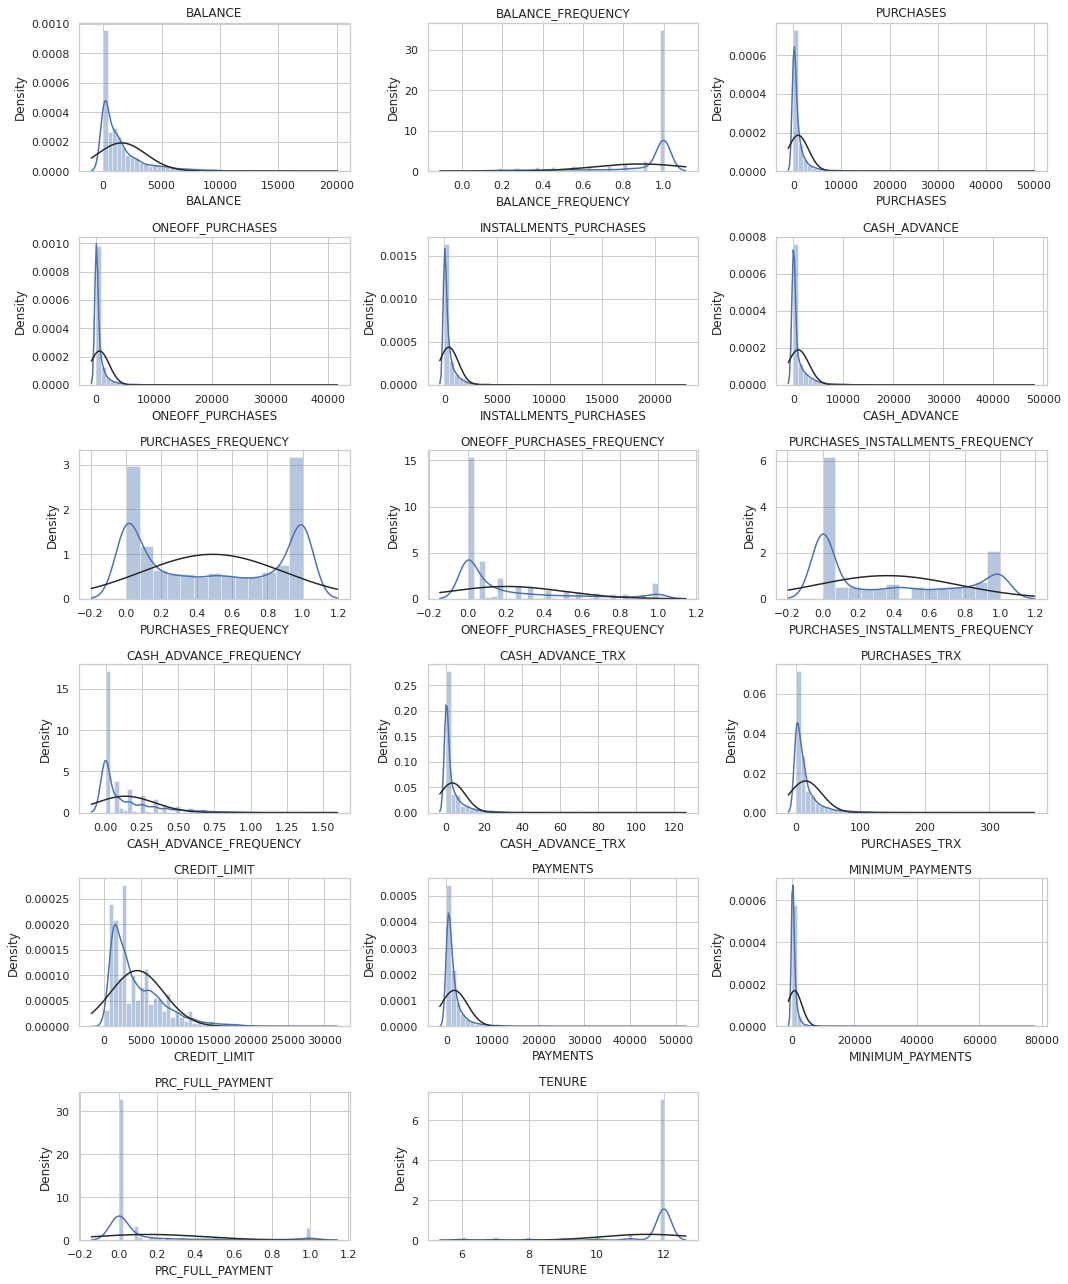

In [11]:
plt.figure(figsize=(15,18))

for i in range(0,17):
    plt.subplot(6,3,i+1)
    sns.distplot(raw_df[raw_df.columns[i]], fit = norm)
    plt.title(raw_df.columns[i])
plt.tight_layout()

Not surprisingly the data is not symmetric* and not even close to a normal distribution. Hence, we will need some transformation to reduce the skewness.

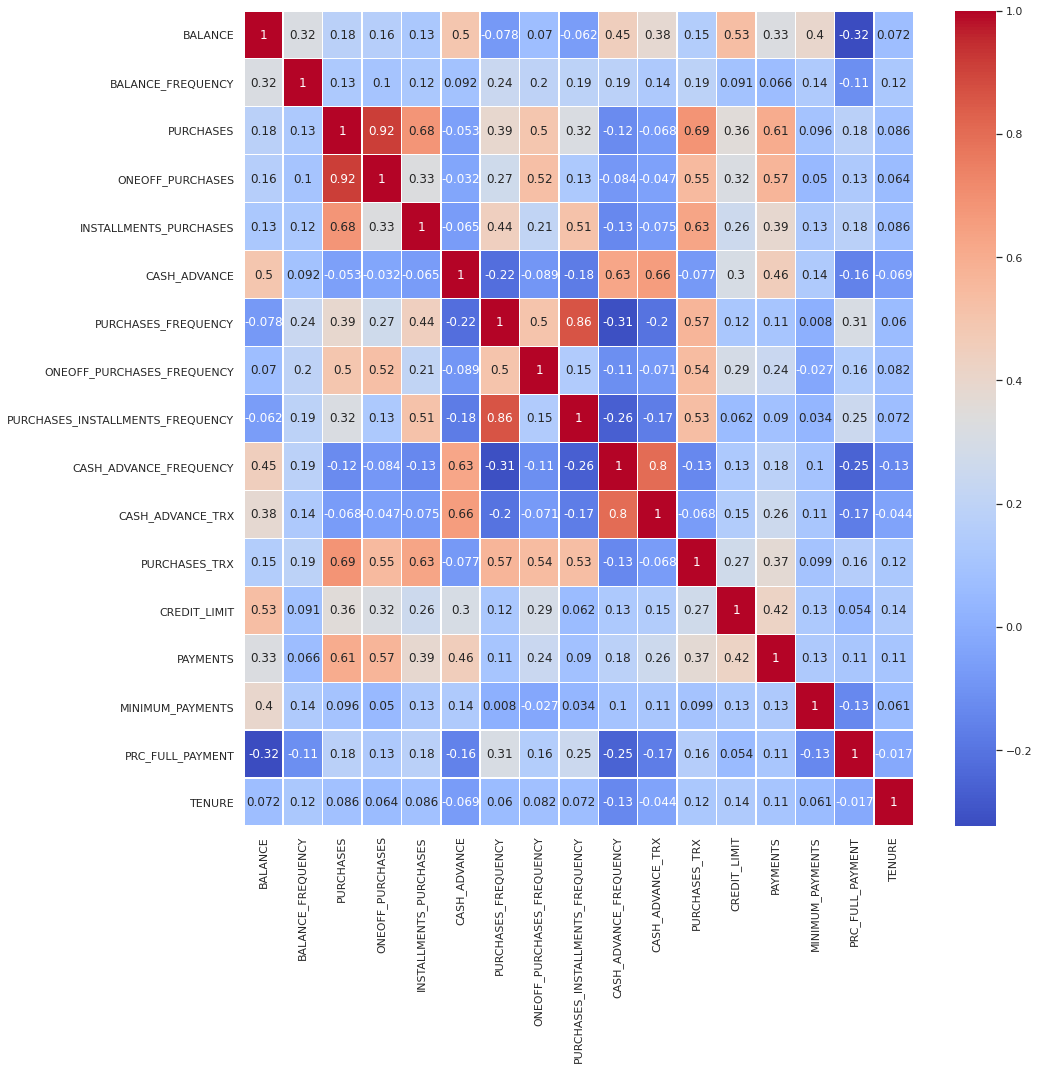

In [12]:
plt.figure(figsize = (15,15))
sns.heatmap(raw_df.corr(), cmap = 'coolwarm', linewidths = .5, annot = True)
plt.show()

# Data Preparation

Moving on, Ive decided to use all of the variables, since there are just a few high correlated (0.8>).
As we can see in the first section of the notebook, the TENURE column is a categorical feature, hence we can't directly use K-Means with the whole data. So what do we do?

1. One-hot encode TENURE column
2. Standard the data
3. Reduce the dimensionality with PCA
4. Use the appropriated clustering algorithm

In [13]:
raw_df['TENURE'] = raw_df['TENURE'].astype('category')

df = pd.get_dummies(raw_df, columns = ['TENURE'])
df.head()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,...,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE_6,TENURE_7,TENURE_8,TENURE_9,TENURE_10,TENURE_11,TENURE_12
CUST_ID,,,,,,,,,,,,,,,,,,,,,
C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,...,201.802084,139.509787,0.000000,0,0,0,0,0,0,1
C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,...,4103.032597,1072.340217,0.222222,0,0,0,0,0,0,1
C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,...,622.066742,627.284787,0.000000,0,0,0,0,0,0,1
C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,...,0.000000,0.000000,0.000000,0,0,0,0,0,0,1
C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,...,678.334763,244.791237,0.000000,0,0,0,0,0,0,1


In [14]:
scaler = StandardScaler()

df[df.columns] = scaler.fit_transform(df[df.columns])
df

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,...,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE_6,TENURE_7,TENURE_8,TENURE_9,TENURE_10,TENURE_11,TENURE_12
CUST_ID,,,,,,,,,,,,,,,,,,,,,
C10001,-0.736905,-0.287766,-0.426040,-0.357926,-0.349910,-0.468992,-0.806206,-0.681576,-0.705852,-0.678664,...,-0.531938,-0.299201,-0.528346,-0.152217,-0.147102,-0.149483,-0.14099,-0.163827,-0.206496,0.423716
C10002,0.779306,0.113037,-0.470533,-0.357926,-0.455019,2.593303,-1.221417,-0.681576,-0.915619,0.567547,...,0.820499,0.098709,0.229157,-0.152217,-0.147102,-0.149483,-0.14099,-0.163827,-0.206496,0.423716
C10003,0.440093,0.513839,-0.109937,0.106237,-0.455019,-0.468992,1.269844,2.662996,-0.915619,-0.678664,...,-0.386245,-0.091135,-0.528346,-0.152217,-0.147102,-0.149483,-0.14099,-0.163827,-0.206496,0.423716
C10004,0.042775,-1.089371,0.228579,0.541981,-0.455019,-0.371182,-1.013812,-0.402863,-0.915619,-0.263262,...,-0.601897,-0.358710,-0.528346,-0.152217,-0.147102,-0.149483,-0.14099,-0.163827,-0.206496,0.423716
C10005,-0.364364,0.513839,-0.463071,-0.348321,-0.455019,-0.468992,-1.013812,-0.402863,-0.915619,-0.678664,...,-0.366739,-0.254292,-0.528346,-0.152217,-0.147102,-0.149483,-0.14099,-0.163827,-0.206496,0.423716
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C19185,-0.663687,-0.220968,0.001790,0.250055,-0.455019,-0.468992,-0.390997,0.433280,-0.915619,-0.678664,...,-0.601897,-0.358710,-0.528346,6.569566,-0.147102,-0.149483,-0.14099,-0.163827,-0.206496,-2.360074
C19186,-0.742855,0.513839,-0.334759,-0.357926,-0.134270,-0.468992,1.269844,-0.681576,1.182052,-0.678664,...,-0.489023,-0.337857,1.176038,6.569566,-0.147102,-0.149483,-0.14099,-0.163827,-0.206496,-2.360074
C19188,-0.745298,-0.220968,-0.403187,-0.357926,-0.295923,-0.468992,0.854633,-0.681576,0.762519,-0.678664,...,-0.573723,-0.323554,0.323846,6.569566,-0.147102,-0.149483,-0.14099,-0.163827,-0.206496,-2.360074


# Principal Component Analysis

Principal Component Analysis, or PCA, is a dimensionality-reduction method that is often used to reduce the dimensionality of large data sets, by transforming a large set of variables into a smaller one that still contains most of the information in the large set. I.e, less variables without losing too much information.


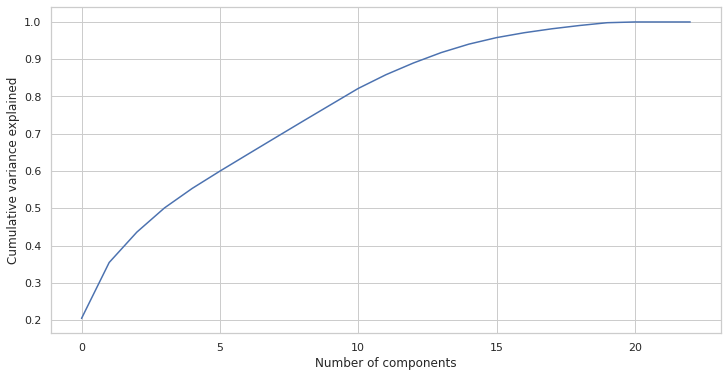

In [45]:
# Identify the ideal number of components by the variance explained
pca = PCA().fit(df)

plt.figure(figsize = (12,6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative variance explained')
plt.show()

Hence, I will select the 90% mark, which is 13 components.


In [47]:
pca.explained_variance_

array([4.69655192e+00, 3.45591645e+00, 1.87557864e+00, 1.49598291e+00,
       1.20181562e+00, 1.06658405e+00, 1.03180836e+00, 1.02697402e+00,
       1.02271310e+00, 1.01331901e+00, 1.01049626e+00, 8.46931764e-01,
       7.28343432e-01, 6.39587578e-01, 5.21540476e-01, 4.02457491e-01,
       3.01654309e-01, 2.43246027e-01, 2.03170478e-01, 1.72268476e-01,
       4.56395003e-02, 1.16587847e-05, 8.03518946e-32])

In [43]:
df_pca = PCA(0.9).fit_transform(df)
df_pca


array([[-1.60110326e+00, -1.12898400e+00, -7.68726119e-01, ...,
         7.55234897e-01, -1.09887423e-01, -1.23286973e-01],
       [-1.09583369e+00,  2.45067969e+00, -6.93085493e-01, ...,
        -6.56643752e-01,  7.84347061e-02, -7.75614749e-01],
       [ 1.02510773e+00, -4.04446457e-01, -7.38557717e-01, ...,
        -1.66018839e+00,  1.98987486e-03,  8.61761967e-01],
       ...,
       [-1.09983636e+00, -1.77645612e+00,  3.09076474e+00, ...,
         1.43332226e-01, -2.56347624e-01, -4.36576864e-01],
       [-2.51306344e+00, -6.51749294e-01,  3.01151605e+00, ...,
         6.19774783e-01,  1.78116551e-01, -8.33317338e-01],
       [-7.65087932e-01, -3.71865179e-01,  3.40729567e+00, ...,
         3.03099612e-01, -1.28439758e-01,  1.30456283e+00]])

# Modeling

We will use the silhouette plot and score to choose the otimal number of clusters!

In [39]:
def silhouette_ploter(array, upper_range):
    ''' Input array and upper limit of cluster to iterate over '''
    
    range_n_clusters = range(2,upper_range)
    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1
        ax1.set_xlim([-1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(array) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters=n_clusters, random_state=10, n_jobs = 4)
        cluster_labels = clusterer.fit_predict(array)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(array, cluster_labels)
        print("For n_clusters =", n_clusters,
              "The average silhouette_score is :", silhouette_avg)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(array, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-1,-0.8, -0.6, -0.4,-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(array[:, 0], array[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                    c=colors, edgecolor='k')

        # Labeling the clusters
        centers = clusterer.cluster_centers_
        # Draw white circles at cluster centers
        ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                    c="white", alpha=1, s=200, edgecolor='k')

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                        s=50, edgecolor='k')

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                      "with n_clusters = %d" % n_clusters),
                     fontsize=14, fontweight='bold')


For n_clusters = 2 The average silhouette_score is : 0.1791947738072624
For n_clusters = 3 The average silhouette_score is : 0.21201492337663155
For n_clusters = 4 The average silhouette_score is : 0.24998113632782257
For n_clusters = 5 The average silhouette_score is : 0.19550568362788426
For n_clusters = 6 The average silhouette_score is : 0.21280347675065794
For n_clusters = 7 The average silhouette_score is : 0.23651034385299258
For n_clusters = 8 The average silhouette_score is : 0.25403255753586984
For n_clusters = 9 The average silhouette_score is : 0.24189699302761275
For n_clusters = 10 The average silhouette_score is : 0.2620556783819623
For n_clusters = 11 The average silhouette_score is : 0.28219123562256676


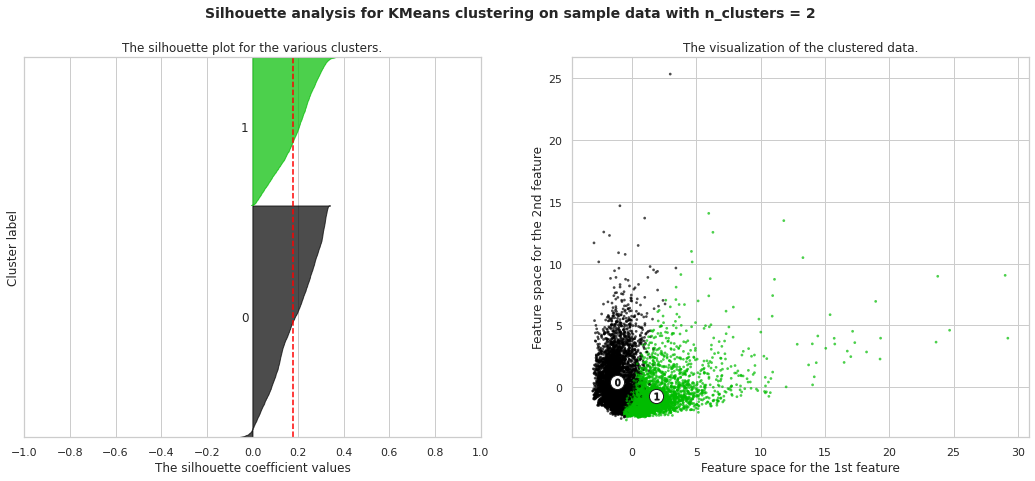

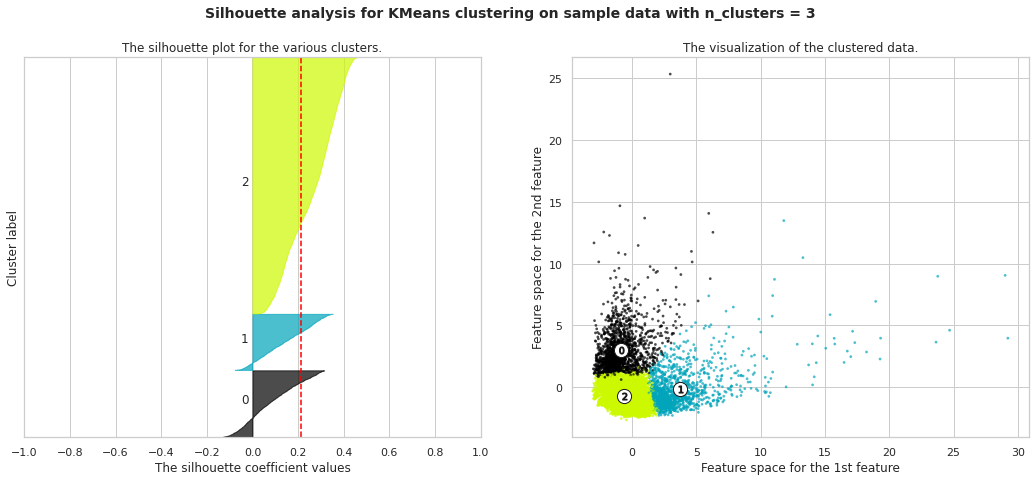

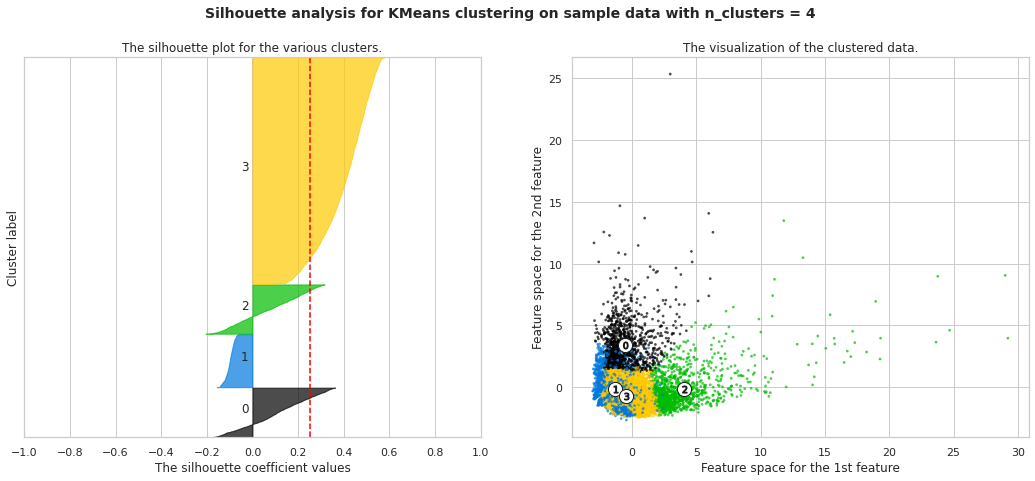

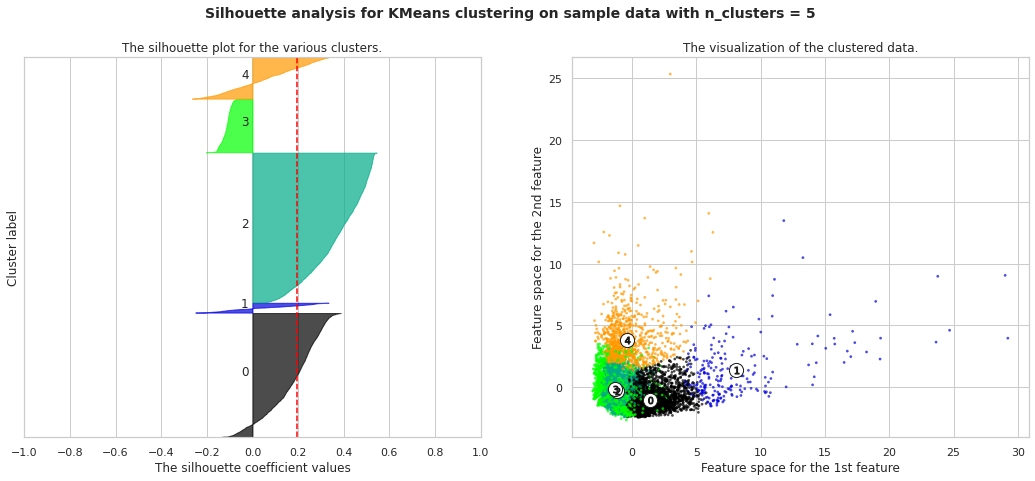

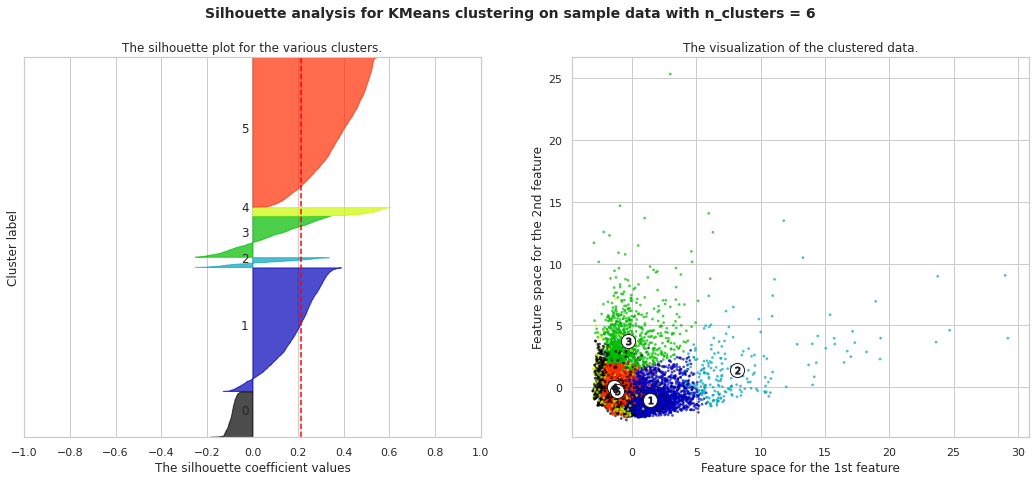

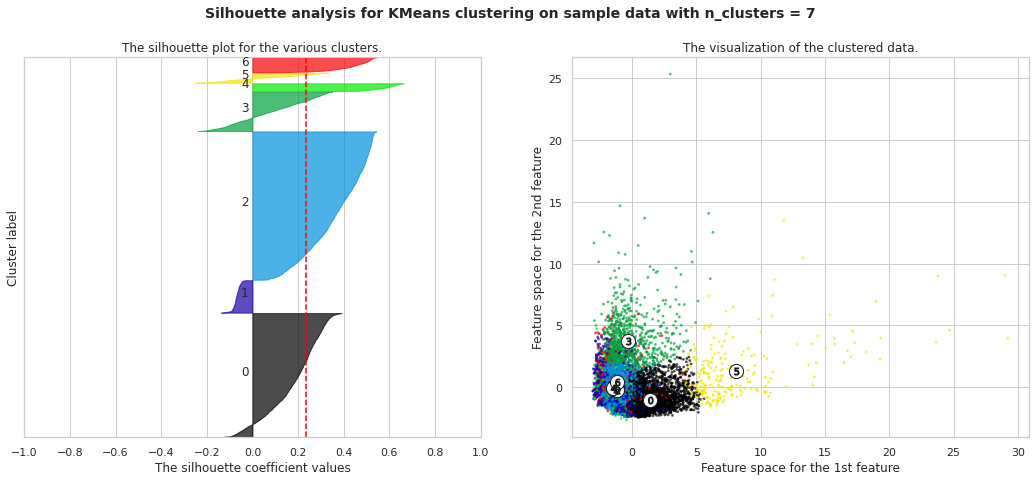

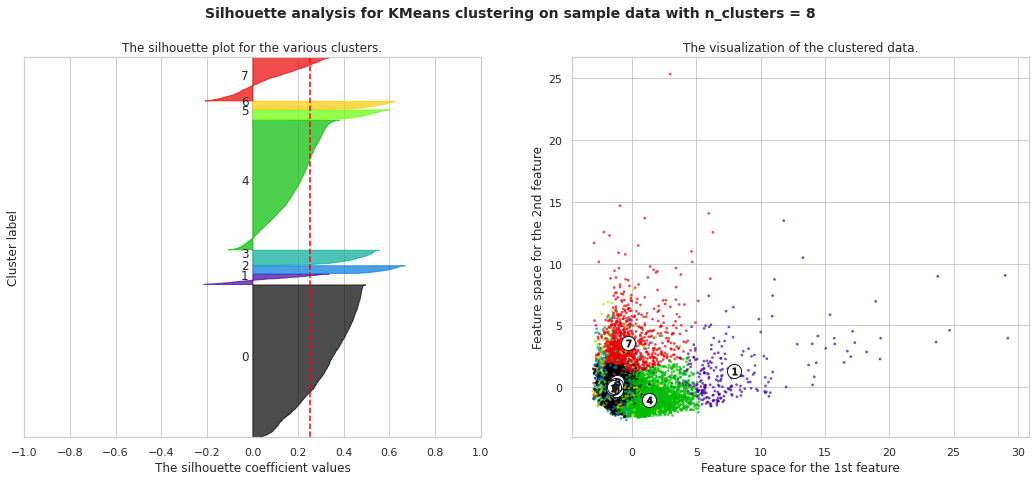

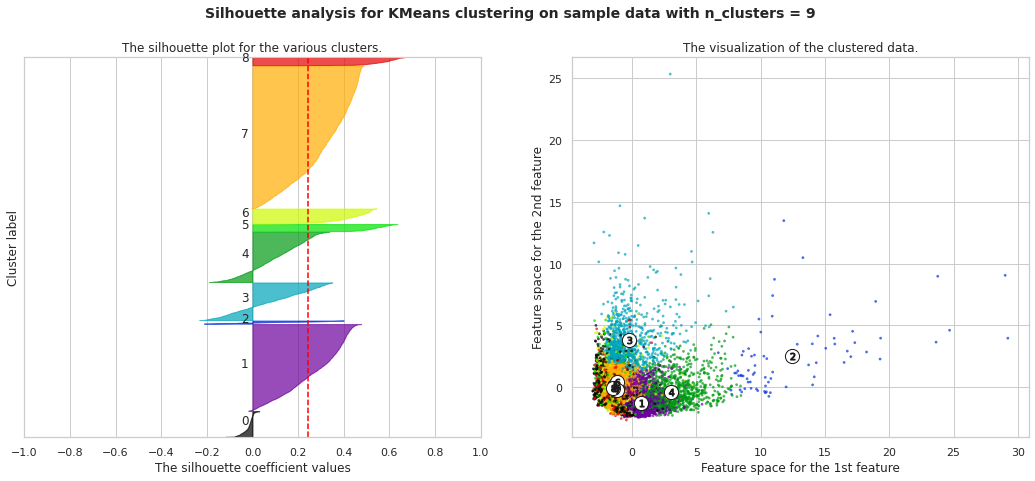

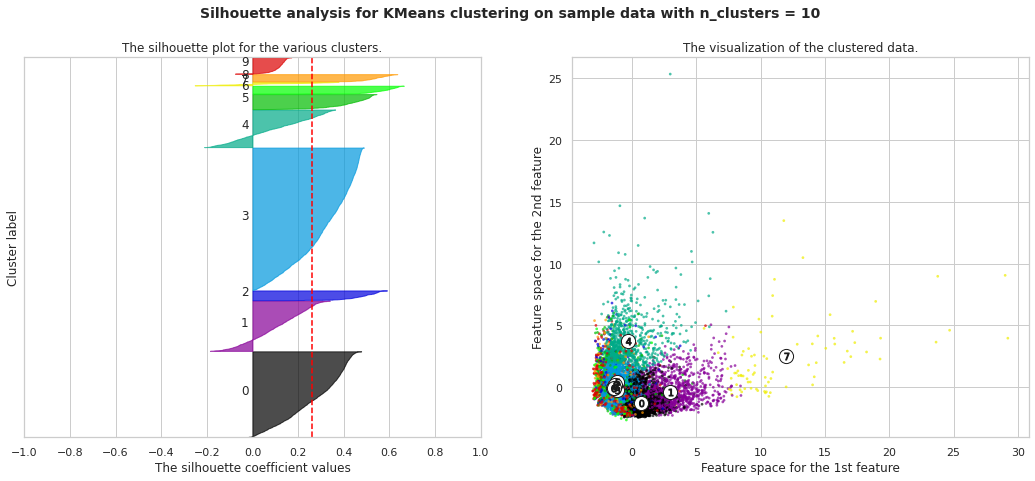

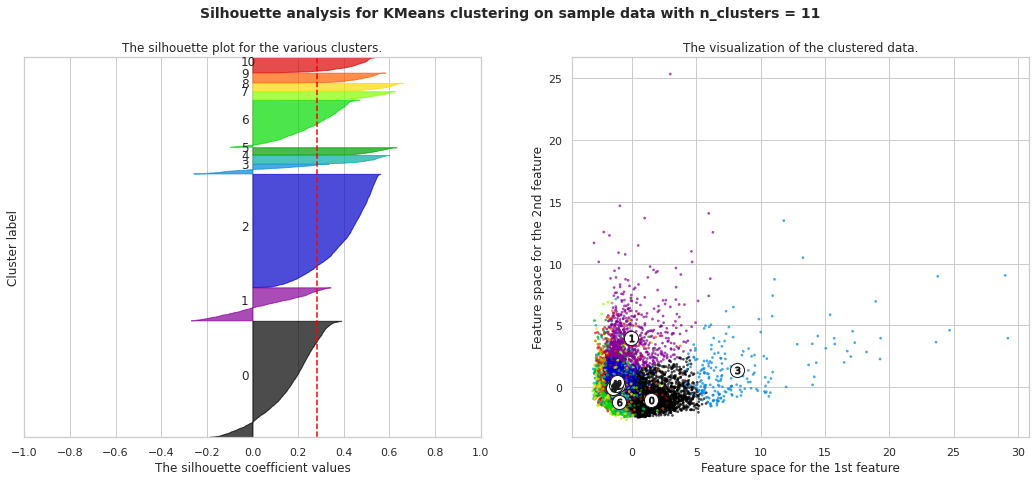

In [40]:
silhouette_ploter(df_pca, 12)

From the silhouette plots and score we can see that the appropriated cluster number is equal to 3, since the avg score is higher and there are not negative coefficients.
Let's use the elbow method as well and see if we get any surprise.

In [41]:
def elbow_plotter(array, upper_limit):
    distortions = []
    k = range(2,upper_limit)
    for n_clusters in k:
        kmeanModel = KMeans(n_clusters=n_clusters, n_jobs = 4, random_state = 8 )
        kmeanModel.fit(array)
        distortions.append(kmeanModel.inertia_)
    plt.figure(figsize=(16,8))
    plt.plot(k, distortions, marker = 'o', linestyle = '--')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method showing the optimal k')
    plt.show()


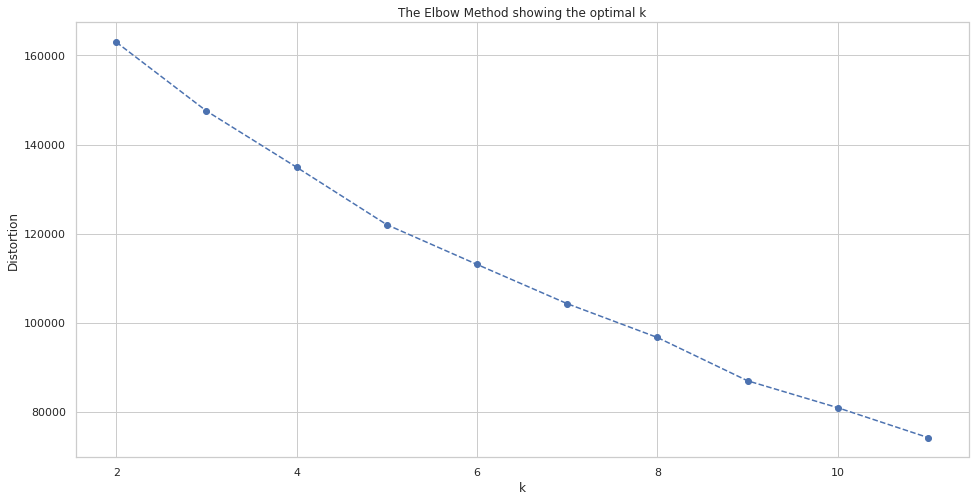

In [42]:
elbow_plotter(df_pca, 12)

# Evaluation

# Conclusion